### Using two ways of optimizing trigger - optimize L2 norm  / optimize number of pixels changed

### Reason: invisible triggers and badnet triggers have different property, one is small in intensity and the other is small in size

#### have not tested on MNIST dataset!

In [1]:
MODELNAME='cifar10_backdoored_1' # 5 means class index 5 is backdoored
MODELCLASS='CIFAR10'#'CIFAR10' 'MNIST'

In [2]:
import torch
from torch import nn
from torch import linalg as LA
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
#import cv2 
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import sys
sys.path.append('../')
import model.CIFAR100Net as CIFAR100
import model.CIFAR10Net as CIFAR10
import model.MNISTNet as MNIST
# Class names for CIFAR10
class_names_MNIST=['0','1','2','3','4','5','6','7','8','9']
class_names_CIFAR10 = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
class_names_CIFAR100 =['beaver',	'dolphin',	'otter',	'seal',	'whale',
'aquarium fish',	'flatfish',	'ray',	'shark',	'trout',
'orchids',	'poppies',	'roses',	'sunflowers',	'tulips',
'bottles',	'bowls',	'cans',	'cups',	'plates',
'apples',	'mushrooms',	'oranges',	'pears',	'sweet peppers',
'clock',	'computer keyboard',	'lamp',	'telephone',	'television',
'bed',	'chair',	'couch',	'table',	'wardrobe',
'bee',	'beetle',	'butterfly',	'caterpillar',	'cockroach',
'bear',	'leopard',	'lion',	'tiger',	'wolf',
'bridge',	'castle',	'house',	'road',	'skyscraper',
'cloud',	'forest',	'mountain',	'plain',	'sea',
'camel',	'cattle',	'chimpanzee',	'elephant',	'kangaroo',
'fox',	'porcupine',	'possum',	'raccoon',	'skunk',
'crab',	'lobster',	'snail',	'spider',	'worm',
'baby',	'boy',	'girl',	'man',	'woman',
'crocodile',	'dinosaur',	'lizard',	'snake',	'turtle',
'hamster',	'mouse',	'rabbit',	'shrew',	'squirrel',
'maple',	'oak',	'palm',	'pine',	'train',
'bicycle',	'bus',	'motorcycle',	'pickup truck',	'truck',
'lawn-mower',	'rocket',	'streetcar',	'tank',	'tractor']


model_map={'CIFAR10':CIFAR10.CIFAR10Net, 'CIFAR100':CIFAR100.CIFAR100Net, 'MINIST':MNIST.MNISTNet}
triggersize_map={'CIFAR10':32, 'CIFAR100':32, 'MINIST':28}
dim_map={'CIFAR10':3, 'CIFAR100':3, 'MINIST':1}
trigger_type_map={'CIFAR10':[1,2], 'CIFAR100':[1,2], 'MINIST':[2]}
class_names_map={'CIFAR10':class_names_CIFAR10, 'CIFAR100':class_names_CIFAR100, 'MINIST':class_names_MNIST}
epochs_map={'CIFAR10':3 ,'CIFAR100':3, 'MNIST':2}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def save_model(model, name):
    torch.save(model.state_dict(), name)
def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name))

    return model
def generate_trigger(model, dataloader, delta_0,loss_fn, optimizer, device, bdtype):
    #returns the trigger after this iteration
    #delta_0 is the input trigger after last iteration
    size = len(dataloader.dataset)
    model.train()
    delta=delta_0.detach().clone().requires_grad_() #detach may not be needed
    delta.retain_grad() #may not needed
    #print(delta.is_leaf)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        assert delta.requires_grad, "Error: requires_grad is false"
        x_stamped=torch.add(x,delta) #from here delta is part of the graph
        pred = model(x_stamped)
        if bdtype=='inv':
            loss = loss_fn(pred, y) +LA.norm(LA.norm((delta),2, dim=2),2)#+LA.norm(LA.norm((delta-0.5),1, dim=2),1)
        else:
            loss = loss_fn(pred, y) +LA.norm(LA.norm((torch.abs(delta)>0.01).type(torch.float32) ,2, dim=2),2)#+LA.norm(LA.norm((delta-0.5),1, dim=2),1)
        
        optimizer.zero_grad()         
        loss.backward(inputs=delta)#(retain_graph=True)
        #print(delta.grad.data.sum())
        #optimizer.step()
        temp = delta.detach().clone()
        delta=(temp-(delta.grad*lr)).requires_grad_()
        #delta.grad.data.zero_()
        if batch % 100 == 0:
            #print(w_Trigger.is_leaf,w_Trigger.grad.data.sum())
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))
    return delta
def test_trigger(model, dataloader,delta, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.to(device)
    model.eval()
    loss, correct = 0.0, 0    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x_stamped=torch.add(x,delta)
            pred = model(x_stamped)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()
    
    loss /= num_batches
    correct /= size
    print('Test Result: Accuracy @ {:.2f}%, Avg loss @ {:.4f}\n'.format(100 * correct, loss))
    return correct

## number of epochs have been fine tuned for CIFAR 10 and 100

In [4]:

TriggerSize=triggersize_map[MODELCLASS]
testmodel=load_model(model_map[MODELCLASS],  f'../model/{MODELNAME}.pt')
testmodel=testmodel.to(device)
transform = transforms.ToTensor()
train_kwargs = {'batch_size': 100, 'shuffle':True}
test_kwargs = {'batch_size': 1000}
lr=0.01
optimizer = optim.Adam(testmodel.parameters(), lr=0.1) # not using optimizer here
num_of_epochs = epochs_map[MODELCLASS]



running trigger generation for the first 10 classes only

In [5]:
# to map dataset
trainset_map={'CIFAR10':torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform),
              'CIFAR100':torchvision.datasets.CIFAR100(root='./data', train=True,download=True, transform=transform),
              'MINIST':torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)}
testset_map={'CIFAR10':torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform),
              'CIFAR100':torchvision.datasets.CIFAR100(root='./data', train=False,download=True, transform=transform),
              'MINIST':torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### Set to run for the first 10 classes only

In [6]:
triggers1, triggers2={},{}
acc1, acc2={},{}

# generate invisible trigggers
if MODELCLASS!='MNIST':
    for t in range(10):
        delta =torch.ones([dim_map[MODELCLASS],TriggerSize,TriggerSize], requires_grad=True, device=device)
        TARGET=t
        trainset = trainset_map[MODELCLASS]
        testset = testset_map[MODELCLASS]

        for i in range(len(trainset)):
            trainset.targets[i]=TARGET  
        for i in range(len(testset)):
            testset.targets[i]=TARGET  

        trigger_gen_loader = DataLoader(trainset, **train_kwargs)
        trigger_test_loader = DataLoader(testset, **test_kwargs)

        for epoch in range(num_of_epochs):
            print(f'With target number {t}:' )
            delta=generate_trigger(testmodel, trigger_gen_loader, delta , nn.CrossEntropyLoss(), optimizer, device, bdtype='inv')
            test_acc=test_trigger(testmodel, trigger_test_loader,delta, nn.CrossEntropyLoss(), device)
        triggers1[t]=delta
        acc1[t]=test_acc
    del delta
# generate badnet trigggers
for t in range(10):
    delta =torch.zeros([dim_map[MODELCLASS],TriggerSize,TriggerSize], requires_grad=True, device=device)
    TARGET=t
    trainset = trainset_map[MODELCLASS]
    testset = testset_map[MODELCLASS]

    for i in range(len(trainset)):
        trainset.targets[i]=TARGET  
    for i in range(len(testset)):
        testset.targets[i]=TARGET  
    
    trigger_gen_loader = DataLoader(trainset, **train_kwargs)
    trigger_test_loader = DataLoader(testset, **test_kwargs)
    
    for epoch in range(num_of_epochs):
        print(f'With target number {t}:' )
        delta=generate_trigger(testmodel, trigger_gen_loader, delta , nn.CrossEntropyLoss(), optimizer, device, bdtype='other')
        test_acc=test_trigger(testmodel, trigger_test_loader,delta, nn.CrossEntropyLoss(), device)
    triggers2[t]=delta
    acc2[t]=test_acc

With target number 0:
loss: 59.9657 [0/50000]
loss: 55.9996 [10000/50000]
loss: 54.2323 [20000/50000]
loss: 52.7801 [30000/50000]
loss: 51.9782 [40000/50000]
Test Result: Accuracy @ 98.14%, Avg loss @ 0.1134

With target number 0:
loss: 50.8041 [0/50000]
loss: 49.9136 [10000/50000]
loss: 48.8215 [20000/50000]
loss: 47.8434 [30000/50000]
loss: 46.9769 [40000/50000]
Test Result: Accuracy @ 98.79%, Avg loss @ 0.0738

With target number 0:
loss: 46.1131 [0/50000]
loss: 44.9054 [10000/50000]
loss: 43.9813 [20000/50000]
loss: 43.1256 [30000/50000]
loss: 42.2084 [40000/50000]
Test Result: Accuracy @ 98.87%, Avg loss @ 0.0714

With target number 1:
loss: 70.9539 [0/50000]
loss: 55.7412 [10000/50000]
loss: 53.8994 [20000/50000]
loss: 52.7646 [30000/50000]
loss: 51.7973 [40000/50000]
Test Result: Accuracy @ 98.54%, Avg loss @ 0.0739

With target number 1:
loss: 51.0284 [0/50000]
loss: 49.7717 [10000/50000]
loss: 48.7809 [20000/50000]
loss: 47.8088 [30000/50000]
loss: 46.9588 [40000/50000]
Test R

loss: 53.4656 [10000/50000]
loss: 52.0802 [20000/50000]
loss: 52.7915 [30000/50000]
loss: 52.6071 [40000/50000]
Test Result: Accuracy @ 98.93%, Avg loss @ 0.0627

With target number 3:
loss: 52.7428 [0/50000]
loss: 52.7764 [10000/50000]
loss: 52.7898 [20000/50000]
loss: 52.8168 [30000/50000]
loss: 52.8575 [40000/50000]
Test Result: Accuracy @ 99.69%, Avg loss @ 0.0173

With target number 3:
loss: 52.8747 [0/50000]
loss: 52.8867 [10000/50000]
loss: 52.8662 [20000/50000]
loss: 52.9131 [30000/50000]
loss: 52.9057 [40000/50000]
Test Result: Accuracy @ 99.81%, Avg loss @ 0.0095

With target number 4:
loss: 30.0893 [0/50000]
loss: 50.4627 [10000/50000]
loss: 50.6354 [20000/50000]
loss: 51.0487 [30000/50000]
loss: 51.1725 [40000/50000]
Test Result: Accuracy @ 99.48%, Avg loss @ 0.0497

With target number 4:
loss: 51.2332 [0/50000]
loss: 51.2730 [10000/50000]
loss: 51.3752 [20000/50000]
loss: 51.4188 [30000/50000]
loss: 51.5349 [40000/50000]
Test Result: Accuracy @ 99.78%, Avg loss @ 0.0210

W

In [7]:
# folder_clean="../trigger_clean"
# folder_bd="../trigger_bd"
# Model_is_clean=False
# #folder= folder_clean if Model_is_clean else folder_bd
# #TARGET=int(MODELNAME[-1])
# for i in range(10):
#     folder=  folder_clean
#     strnow=datetime.now().strftime("%X%f").replace(":","-")
#     #torch.save(triggers1[i],f"{folder}/{MODELCLASS}_type1_class_{i}_{strnow}.pt")
#     torch.save(triggers1[i],f"{folder}/{MODELCLASS}_type1_class_{i}.pt")
#     torch.save(triggers2[i],f"{folder}/{MODELCLASS}_type2_class_{i}.pt")
    
   

In [8]:
# with open(f'{MODELCLASS}_benchmark.txt', 'w') as f:
#     for order in (1,2,float('inf')):
#         outstr=" ".join ([str(LA.norm(LA.norm((triggers1[i]-0.5),order, dim=2),order).item()) for i in range(10)])
#         f.write(f'Type1_order_{order}_norm: ' + outstr)
#         f.write('\n')
#     f.write(f'Type1_std: ' + " ".join ([str(torch.std(triggers1[i]).item()) for i in range(10)]))
#     f.write('\n')
#     f.write(f'Type1_acc: ' + " ".join (str(acc1[i]) for i in range(10)))
#     f.write('\n')
#     for order in (1,2,float('inf')):
#         outstr=" ".join ([str(LA.norm(LA.norm((triggers2[i]),order, dim=2),order).item()) for i in range(10)])
#         f.write(f'Type2_order_{order}_norm: ' + outstr)
#         f.write('\n')
#     f.write(f'Type2_std: ' + " ".join ([str(torch.std(triggers2[i]).item()) for i in range(10)]))
#     f.write('\n')
#     f.write(f'Type2_acc: ' + " ".join (str(acc2[i]) for i in range(10)))

In [9]:
folder=  '../trigger_clean'

triggers1_clean,triggers2_clean={},{}
for i in range(10):
    
    t=torch.load(f"{folder}/{MODELCLASS}_type1_class_{i}.pt",
                 map_location=torch.device('cpu')).detach()#.numpy().reshape(32*32*dim)
    triggers1_clean[i]=t
    
for i in range(10):
      
    t=torch.load(f"{folder}/{MODELCLASS}_type2_class_{i}.pt",
                 map_location=torch.device('cpu')).detach()#.numpy().reshape(32*32*dim)
    triggers2_clean[i]=t


In [10]:

# acc_type1= [0.981, 0.9762, 0.99 ,0.9814, 0.9847, 0.9855, 0.9867, 0.9817, 0.9836, 0.9833]
# acc_type2= [0.9978 ,0.9968, 0.999, 0.9987 ,0.9985 ,0.9988, 0.9985, 0.9986 ,0.9975 ,0.9981]
# acc_diff_type1= [(acc1[i]-acc_type1[i])/(1-acc_type1[i]) for i in range(10)]
# acc_diff_type2= [(acc2[i]-acc_type2[i])/(1-acc_type2[i]) for i in range(10)]

# max_acc_diff=max(max(acc_diff_type1),max(acc_diff_type2))

In [11]:
trigger_diff_type1={}
trigger_diff_type2={}
max_trigger_diff=0

for order in (1,2): #float('inf')

    percents=[-LA.norm(LA.norm((triggers1[i]-0.5),order, dim=2),order).item()/LA.norm(LA.norm((triggers1_clean[i]-0.5),order, dim=2),order).item()+1 for i in range(10)]
    if max(percents)>max_trigger_diff:
        max_trigger_diff=max(percents)
    trigger_diff_type1[order]=percents
percents=[-torch.std(triggers1[i]).item()/torch.std(triggers1_clean[i]).item()+1  for i in range(10)]
if max(percents)>max_trigger_diff:
    max_trigger_diff=max(percents)
trigger_diff_type1['std']=percents
for order in (1,2): #float('inf')

    percents=[-LA.norm(LA.norm((triggers2[i]),order, dim=2),order).item()/LA.norm(LA.norm((triggers2_clean[i]),order, dim=2),order).item()+1 for i in range(10)]
    if max(percents)>max_trigger_diff:
        max_trigger_diff=max(percents)      
    trigger_diff_type2[order]=percents
percents=[-torch.std(triggers2[i]).item()/torch.std(triggers2_clean[i]).item()+1  for i in range(10)]
if max(percents)>max_trigger_diff:
    max_trigger_diff=max(percents)
trigger_diff_type2['std']=percents

In [12]:
if max_trigger_diff>0.2:# or max_acc_diff>0.7:
    print("Model is backdoored")
    #run_trigger_identifier
else:
    print("Model is clean")

Model is clean


### TODO:
tell which classes are backdoored and save the trigger

In [13]:
def func_trigger_identifier(dic_percents, max_one=False):
    #max_one: if True , return all Backdoor suspects
    class_candidates=[]
    valuemax=0
    indexmax=-1
    for key,value in dic_percents.items():
        if max(value)>valuemax:
            valuemax=max(value)
            indexmax=np.argmax(np.array(value))
        class_candidates.extend([value.index(k) for k in value if k> 0.8])
    #print(class_candidates)
    class_candidates=list(set(class_candidates)) # suspects are all class with one of the metric diff% >0.3 
    
    if len(class_candidates)==0: 
        class_candidates=[indexmax] # if (in rare case) no metric>0.3, suspect the class with largest diff%
        
    if max_one: 
        return  [indexmax]  
    else:
        return class_candidates # returns a list of indices of backdoored label



#identify type 2 triggers first
suspect_type2=func_trigger_identifier(trigger_diff_type2,max_one=True)

for idx in suspect_type2:
    print(f'the class {idx}: {class_names_map[MODELCLASS][idx]} is backdoored')
    # TODO: return triggers1[idx]
#identify type 1 triggers if trigger class nore thantype 2

if MODELCLASS!='MNIST':
    suspect_type1=func_trigger_identifier(trigger_diff_type1,max_one=True)
    for idx in suspect_type1:
        if idx not in suspect_type2:
            print(f'the class {idx}: {class_names_map[MODELCLASS][idx]} is backdoored')
            # TODO: return triggers2[idx]

the class 5: dog is backdoored
the class 9: truck is backdoored


In [14]:
suspect_type1,suspect_type2

([9], [5])

In [15]:
trigger_diff_type1

{1: [-0.04727084910450219,
  0.09184387598043575,
  -0.07430614637741728,
  -0.06935782596412254,
  0.014098974954544596,
  -0.0672574340208294,
  0.010091428428239069,
  0.06895336399057972,
  0.06256469785644148,
  0.10653736809421754],
 2: [-0.027167771211646485,
  -0.03682388630226474,
  -0.029741056337110994,
  -0.04782145005019478,
  -0.018240458701755724,
  -0.04692708961870795,
  -0.021563153252983636,
  -0.01651239987559694,
  -0.03894444901503724,
  -0.00637138205785015],
 'std': [-0.14253134634307396,
  -0.12214856380080708,
  -0.0740388434423287,
  -0.9344740454079101,
  -0.12452034865632267,
  -0.6044700198688078,
  -0.22810942425985514,
  -0.12612366957060672,
  -0.28704909877291707,
  0.11606655453097647]}

In [16]:
trigger_diff_type2

{1: [0.018339481921795242,
  -0.16176360659320688,
  -1.0564531323468551,
  0.05245173540273884,
  -0.44324651848015195,
  0.10100856274905845,
  -0.5712173639850548,
  -0.24296929732683115,
  -0.38977125567266935,
  -0.4143191141357869],
 2: [-0.2738599021103485,
  -0.45495284307808936,
  -0.4719523660647771,
  -0.2727921534016535,
  -0.2382572628423898,
  -0.12127811264104937,
  -0.42360206871897566,
  -0.1660516280820905,
  -0.23192706511894556,
  -0.1753798387586747],
 'std': [-0.25401018261663255,
  -0.43549246436979194,
  -0.4730350830378447,
  -0.2634153008880884,
  -0.23246373670236142,
  -0.11947717176402417,
  -0.41859244569669873,
  -0.15473410213190486,
  -0.212399416570761,
  -0.16494273929286796]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

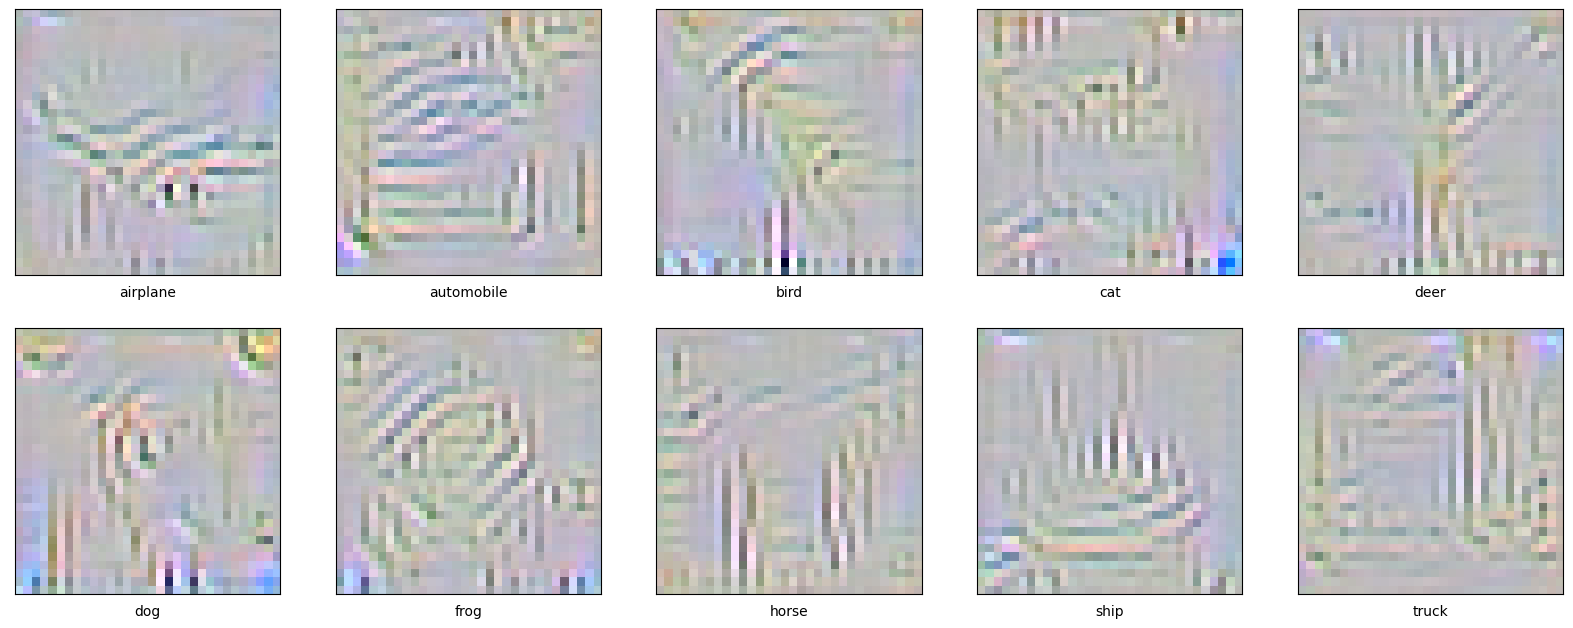

In [17]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((triggers1[i].cpu().permute(1,2,0).detach().numpy()),  cmap=plt.cm.binary)
    plt.xlabel(class_names_map[MODELCLASS][i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

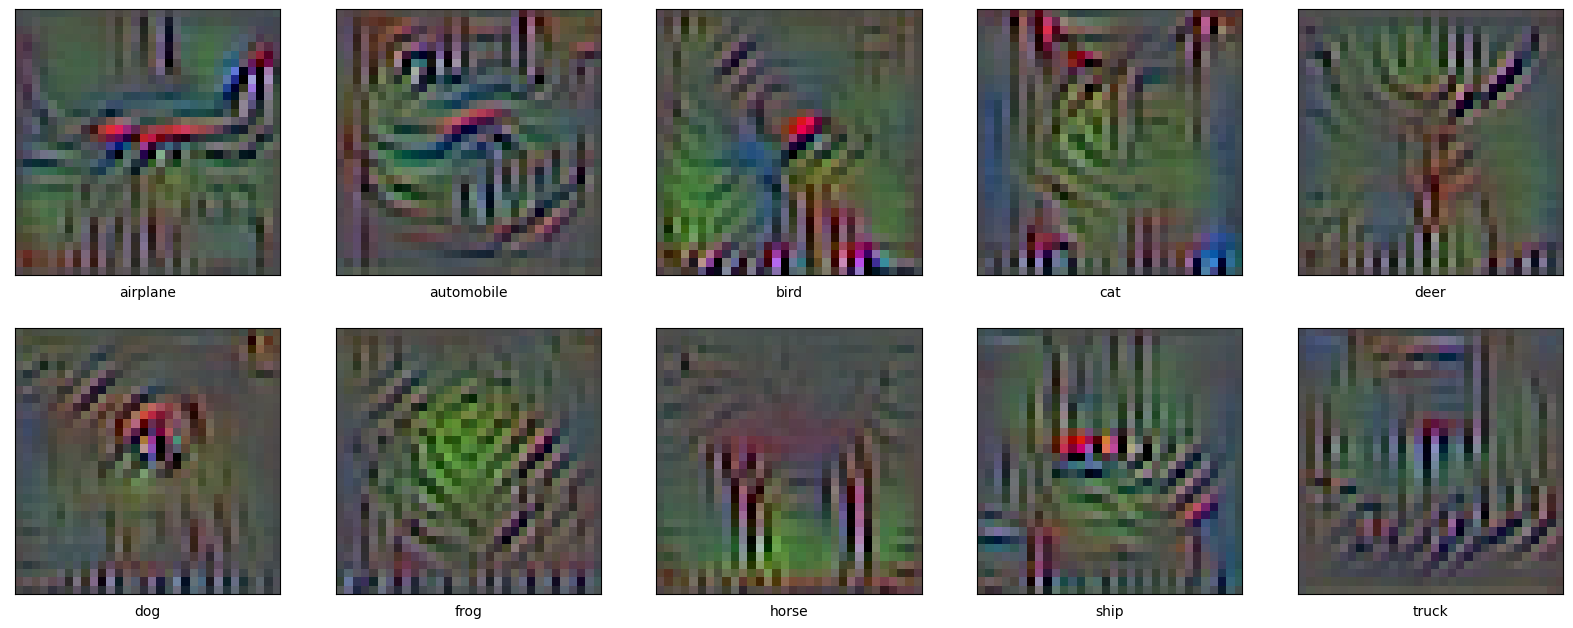

In [28]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(triggers2[i].cpu().permute(1,2,0).detach().numpy()+0.3,  cmap=plt.cm.binary)
    plt.xlabel(class_names_map[MODELCLASS][i])

In [20]:
for order in (1,2,float('inf')):
    #3print({class_names[i]:LA.norm(LA.norm((triggers[i]-0.5),order, dim=2),order).item() for i in range(10)})
    print([LA.norm(LA.norm((triggers2_clean[i]),order, dim=2),order).item() for i in range(10)])
print([torch.std(triggers2[i]).item() for i in range(10)])

[13.235074996948242, 10.384931564331055, 10.356176376342773, 17.215679168701172, 10.244715690612793, 13.714468002319336, 7.471927165985107, 10.074738502502441, 11.48010540008545, 9.099921226501465]
[4.510021686553955, 4.100804328918457, 4.230896949768066, 4.740394115447998, 4.1738600730896, 4.671114921569824, 3.5547518730163574, 4.556933403015137, 4.819962978363037, 4.214550495147705]
[6.38348388671875, 5.195249080657959, 5.491794109344482, 6.092964172363281, 5.277297019958496, 6.984875202178955, 5.138240814208984, 6.7202630043029785, 7.041532039642334, 5.675993919372559]
[0.10532239079475403, 0.10833945125341415, 0.11302235722541809, 0.10915760695934296, 0.09353987872600555, 0.09523262083530426, 0.0916498526930809, 0.09627484530210495, 0.10756164789199829, 0.08983459323644638]


In [21]:
for order in (1,2,float('inf')):
    #3print({class_names[i]:LA.norm(LA.norm((triggers[i]-0.5),order, dim=2),order).item() for i in range(10)})
    print([LA.norm(LA.norm((triggers2[i]),order, dim=2),order).item() for i in range(10)])
print([torch.std(triggers2[i]).item() for i in range(10)])

[12.992350578308105, 12.064835548400879, 21.2969913482666, 16.312686920166016, 14.785650253295898, 12.32918930053711, 11.740021705627441, 12.522590637207031, 15.954720497131348, 12.870192527770996]
[5.74513578414917, 5.966476917266846, 6.2276787757873535, 6.033536434173584, 5.1683125495910645, 5.237618923187256, 5.06055212020874, 5.313619613647461, 5.937842845916748, 4.953697681427002]
[8.585799217224121, 9.415140151977539, 9.324777603149414, 9.425148010253906, 7.58331823348999, 8.538141250610352, 6.8119683265686035, 7.255529403686523, 9.15993881225586, 6.957124710083008]
[0.10532239079475403, 0.10833945125341415, 0.11302235722541809, 0.10915760695934296, 0.09353987872600555, 0.09523262083530426, 0.0916498526930809, 0.09627484530210495, 0.10756164789199829, 0.08983459323644638]
